In [9]:
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from torch.nn import functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, random_split, DataLoader

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw

torch.manual_seed(0)
np.random.seed(0)

In [10]:
with open('hyperparameters.yaml') as f:
    hp = yaml.safe_load(f)['hyperparameters']

In [16]:
train_labels = pd.read_csv('./data/DermMel/train_labels.csv')
val_labels = pd.read_csv('./data/DermMel/val_labels.csv')
test_labels = pd.read_csv('./data/DermMel/test_labels.csv')

train_images = './data/DermMel/train/'
val_images = './data/DermMel/valid/'
test_images = './data/DermMel/test/'

In [17]:
train_labels.head()

,index,id,target
0,0,ISIC_0026529,0
1,1,AUG_0_3997,1
2,2,ISIC_0025285,0
3,3,ISIC_0033070,0
4,4,ISIC_0031685,0


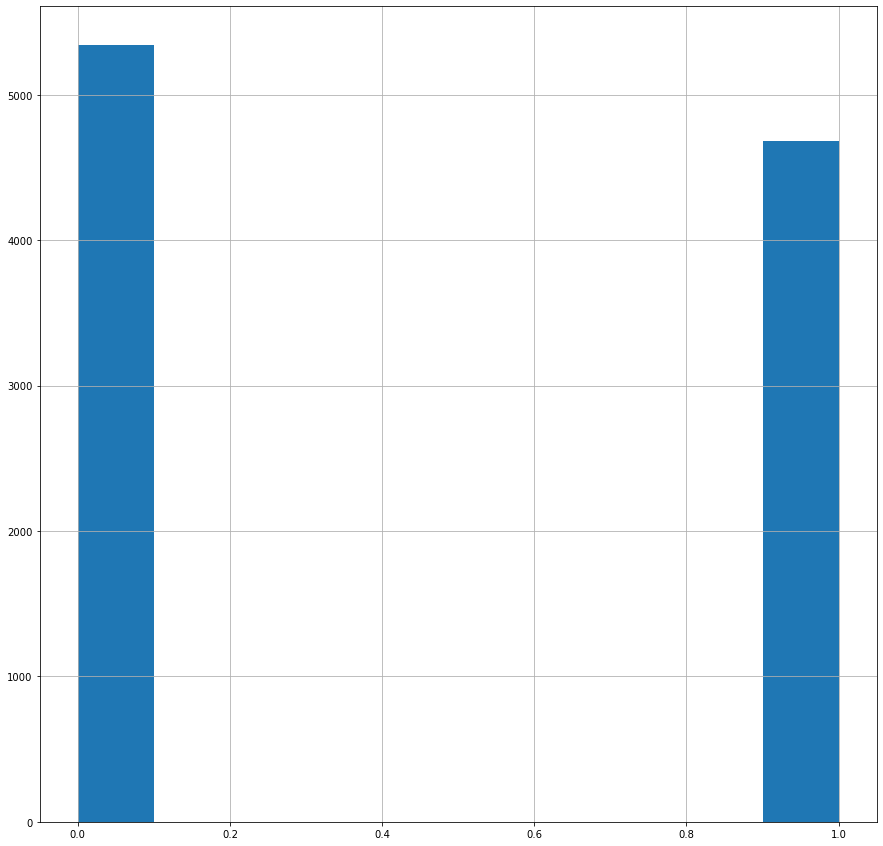

In [18]:
train_labels['target'].hist()

In [19]:
malignant_ids = train_labels.loc[train_labels['target'] == 1]['id'].values
benign_ids = train_labels.loc[train_labels['target'] == 0]['id'].values

print(f'Malignant: {malignant_ids[:15]}')
print(f'Normal: {benign_ids[:15]}')

Malignant: ['AUG_0_3997' 'AUGmented_0_6536' 'AUG_0_538' 'AUG_0_889'
 'AUGmented_0_8594' 'AUG_0_3968' 'AUG_0_3705' 'AUGmented_0_9575'
 'AUG_0_4955' 'AUGmented_0_8392' 'AUGmented_0_4221' 'AUG_0_9794'
 'AUG_0_4436' 'AUGmented_0_3310' 'AUG_0_1744']
Normal: ['ISIC_0026529' 'ISIC_0025285' 'ISIC_0033070' 'ISIC_0031685'
 'ISIC_0025945' 'ISIC_0026480' 'ISIC_0033720' 'ISIC_0028429'
 'ISIC_0033019' 'ISIC_0025574' 'ISIC_0026409' 'ISIC_0031825'
 'ISIC_0026673' 'ISIC_0028886' 'ISIC_0025801']
